In [1]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels as sms
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

## 1) Formulate question

## 2) Gather data

### Background info:

 The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
 prices and the demand for clean air', J. Environ. Economics & Management,
 vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
 ...', Wiley, 1980.   N.B. Various transformations are used in the table on
 pages 244-261 of the latter.

#### Variables (in order):
- **CRIM**: Per capita crime rate by town
- **ZN**: Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: Proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (1 if tract bounds river; 0 
otherwise)
- **NOX**: Nitric oxides concentration (parts per 10 million)
- **RM**: Average number of rooms per dwelling
- **AGE**: Proportion of owner-occupied units built prior to 1940
- **DIS**: Weighted distances to five Boston employment centres
- **RAD**: Index of accessibility to radial highways
- **TAX**: Full-value property-tax rate per $10,000
- **PTRATIO**: Pupil-teacher ratio by town
- **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- **LSTAT**: % lower status of the population
- **MEDV**: Median value of owner-occupied homes in $1000's (target variable)

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston" # Source of the data
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B','LSTAT', 'MEDV'] # Names of the features and label
df = pd.DataFrame(data, columns=columns)
df.shape # Number of data points (rows) and features (columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 3) Clean/preprocess data

In [3]:
# 1) Remove null rows

df.isnull().sum() # Number of missing values
df.dropna(inplace=True)

# 2) Remove duplicates

df.drop_duplicates(inplace=True)

df.shape

(506, 14)

# 4) Visualize data

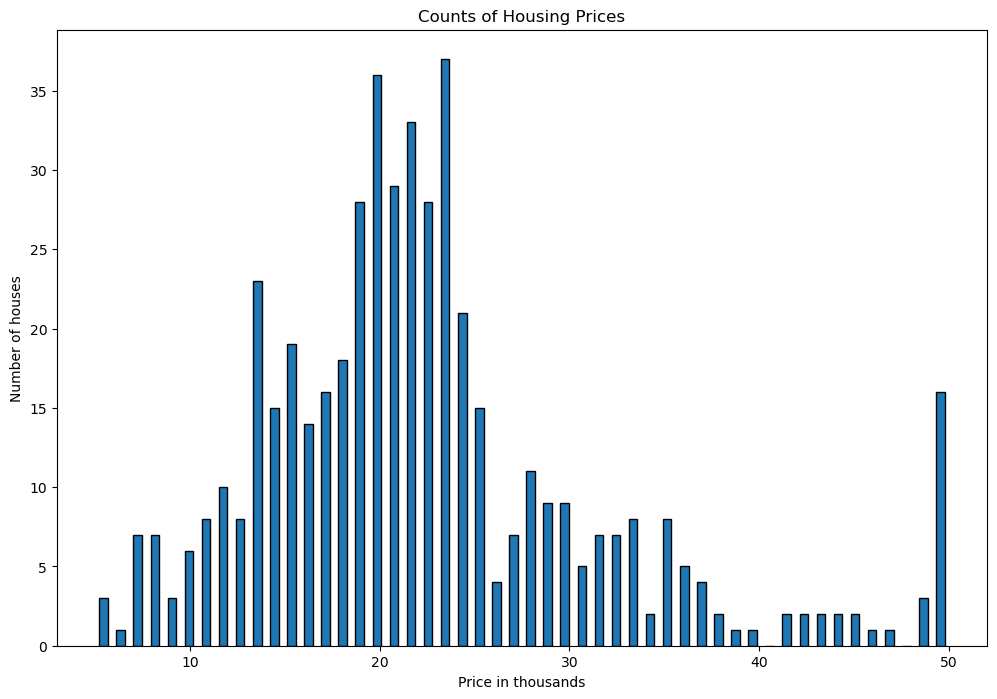

In [4]:
plt.figure(figsize=(12, 8))

plt.hist(df['MEDV'], bins=50, ec='black', rwidth=0.5)
plt.xlabel('Price in thousands')
plt.ylabel('Number of houses')
plt.title("Counts of Housing Prices")
plt.show()

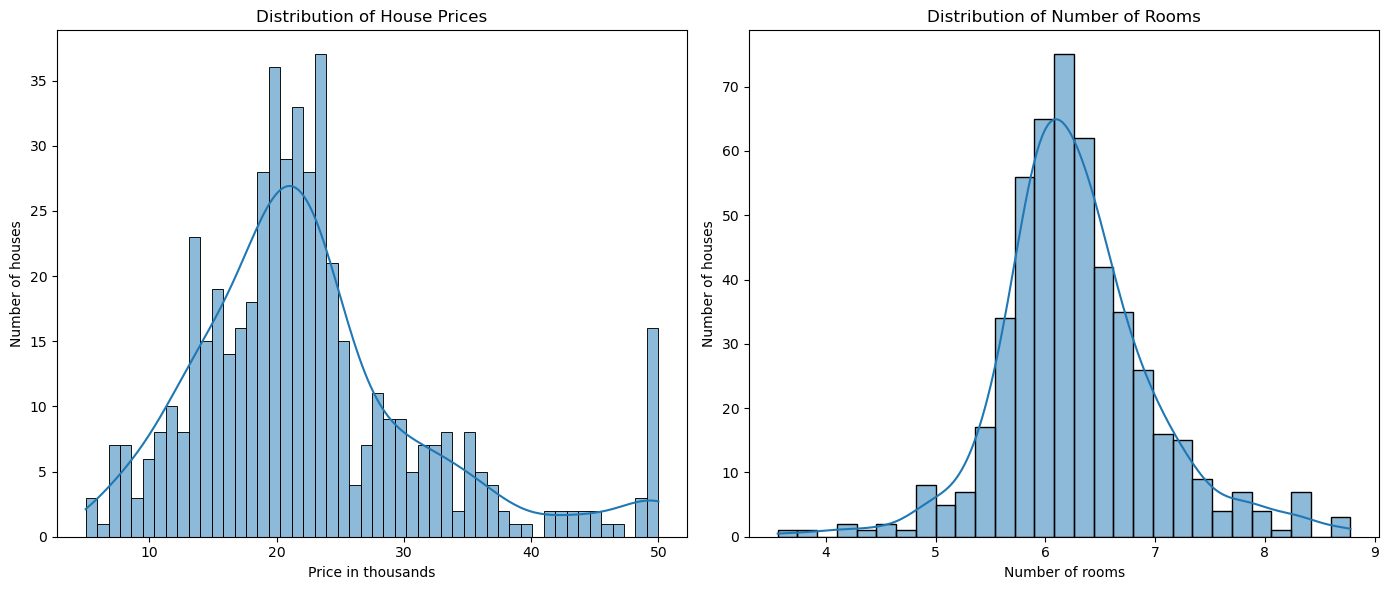

In [5]:
# Set up the figure with subplots for two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of 'MEDV' (house prices)
sns.histplot(df['MEDV'], bins=50, kde=True, ax=axes[0])
axes[0].set_xlabel('Price in thousands')
axes[0].set_ylabel('Number of houses')
axes[0].set_title('Distribution of House Prices')

# Plot the distribution of 'RM' (number of rooms)
sns.histplot(df['RM'], kde=True, ax=axes[1])
axes[1].set_xlabel('Number of rooms')
axes[1].set_ylabel('Number of houses')
axes[1].set_title('Distribution of Number of Rooms')

# Show the combined plots
plt.tight_layout()
plt.show()


# plt.figure(figsize=(12, 8))

# sns.displot(df['MEDV'], bins=50, kde=True)
# plt.xlabel('Price in thousands')
# plt.ylabel('Number of houses')

# plt.figure(figsize=(12, 8))

# sns.displot(df['RM'], kde=True)
# plt.xlabel('Number of rooms')
# plt.ylabel('Number of houses')

# plt.show()

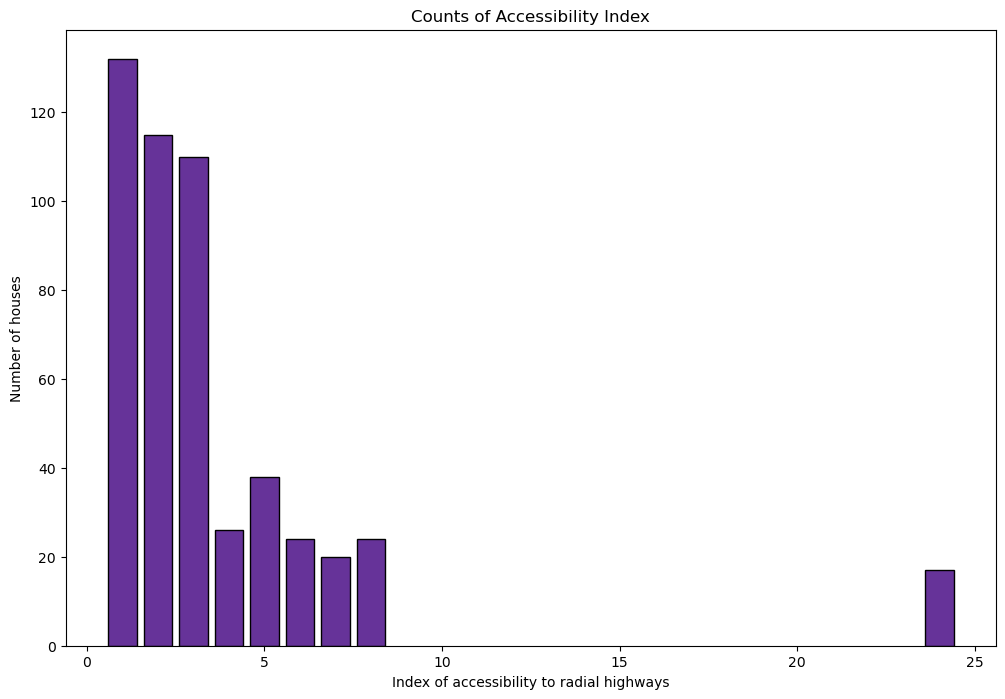

In [6]:
indices = df['RAD'].unique()
frequency = df['RAD'].value_counts()

plt.figure(figsize=(12, 8))

plt.bar(indices, frequency, ec='black', color="#663399")
plt.xlabel('Index of accessibility to radial highways')
plt.ylabel('Number of houses')
plt.title("Counts of Accessibility Index")
plt.show()

## Descriptive Statistics

In [7]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Inferential Statistics

### Correlation

#### $$ \rho _{XY} = Corr(XY) $$
#### $$ -1.0 \leq \rho _{XY} \leq +1.0 $$

In [8]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [9]:
mask = np.zeros_like(df.corr())
upper_triangle = np.triu_indices_from(mask)
mask[upper_triangle] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

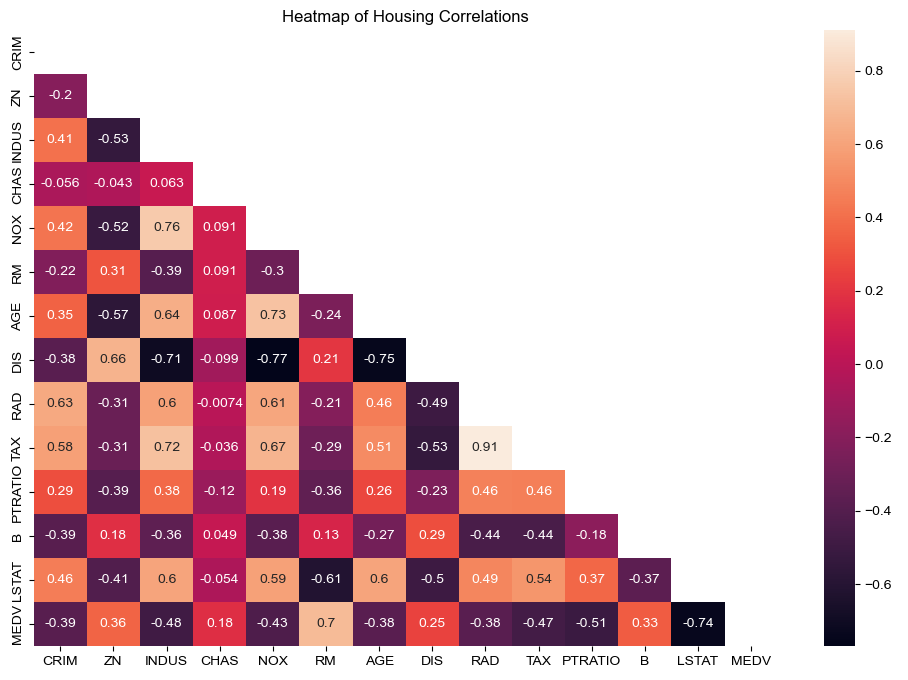

In [10]:
plt.figure(figsize=(12, 8))

sns.heatmap(df.corr(), mask=mask, annot=True).set(title='Heatmap of Housing Correlations')
sns.set_style('white')
plt.show()

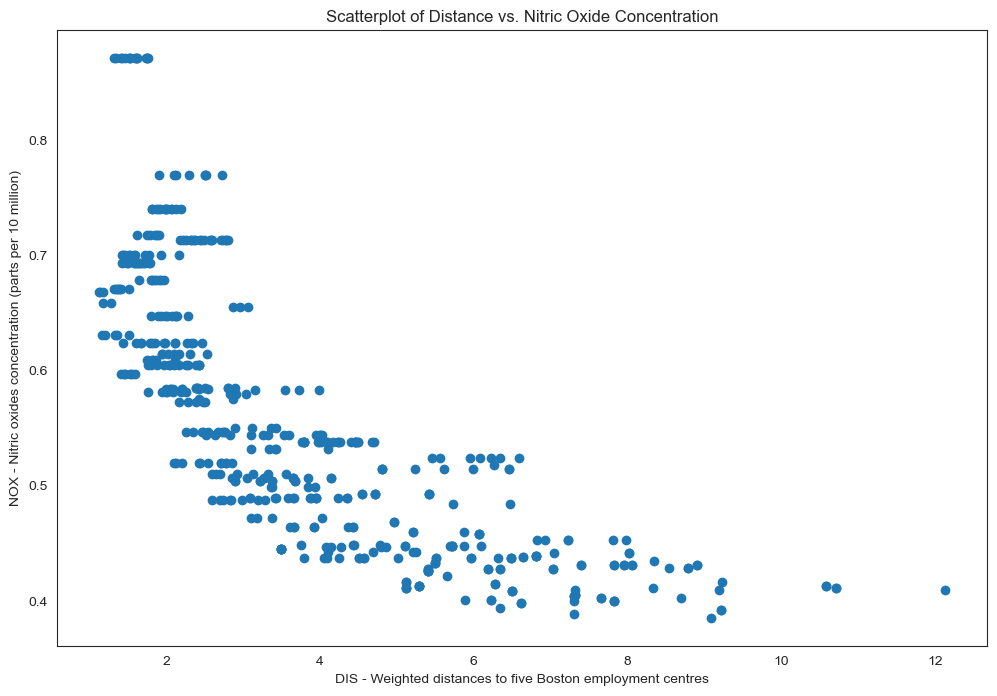

In [11]:
# Relationship between weighted distances to five Boston employment centres (DIS) and nitric oxides concentration (NOX)

plt.figure(figsize=(12, 8))

plt.scatter(x=df['DIS'], y=df['NOX'])
plt.xlabel('DIS - Weighted distances to five Boston employment centres')
plt.ylabel('NOX - Nitric oxides concentration (parts per 10 million)')
plt.title('Scatterplot of Distance vs. Nitric Oxide Concentration')
plt.show()

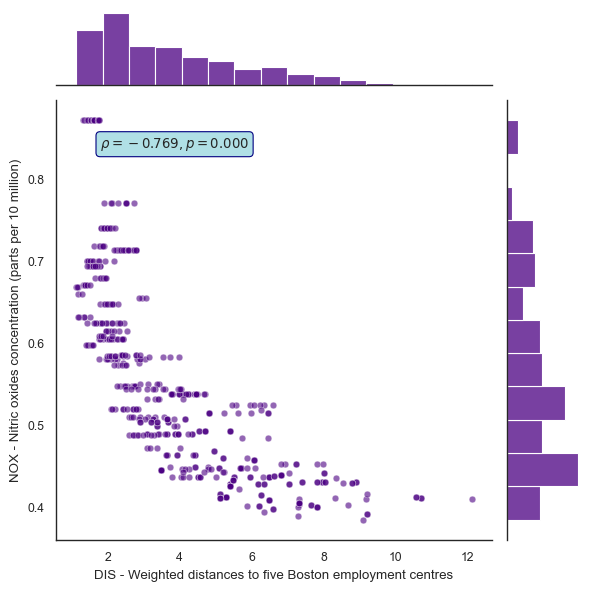

In [12]:
# Note: Seaborn does not have a scatterplot function.

sns.set_context('paper')
g = sns.jointplot(x=df['DIS'], y=df['NOX'], joint_kws={'alpha': 0.6}, color='indigo')

r, p = stats.pearsonr(x=df['DIS'], y=df['NOX'])
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
plt.xlabel('DIS - Weighted distances to five Boston employment centres')
plt.ylabel('NOX - Nitric oxides concentration (parts per 10 million)')
plt.show()

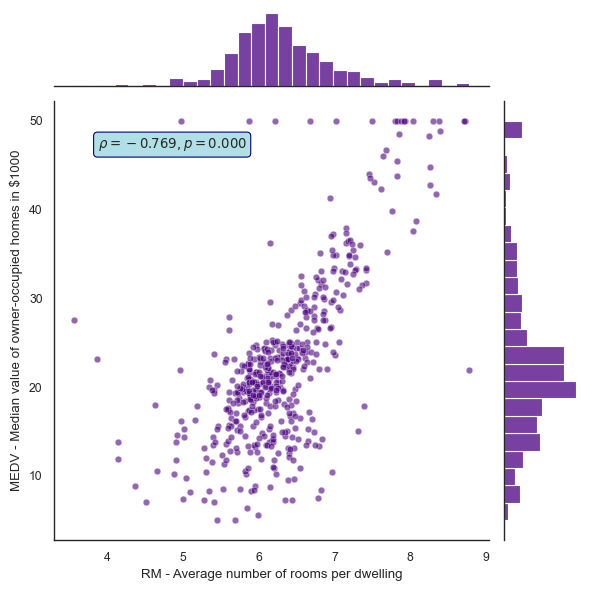

In [13]:
sns.set_context('paper')
g = sns.jointplot(x=df['RM'], y=df['MEDV'], joint_kws={'alpha': 0.6}, color='indigo')

g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
plt.xlabel('RM - Average number of rooms per dwelling')
plt.ylabel('MEDV - Median value of owner-occupied homes in $1000')
plt.show()

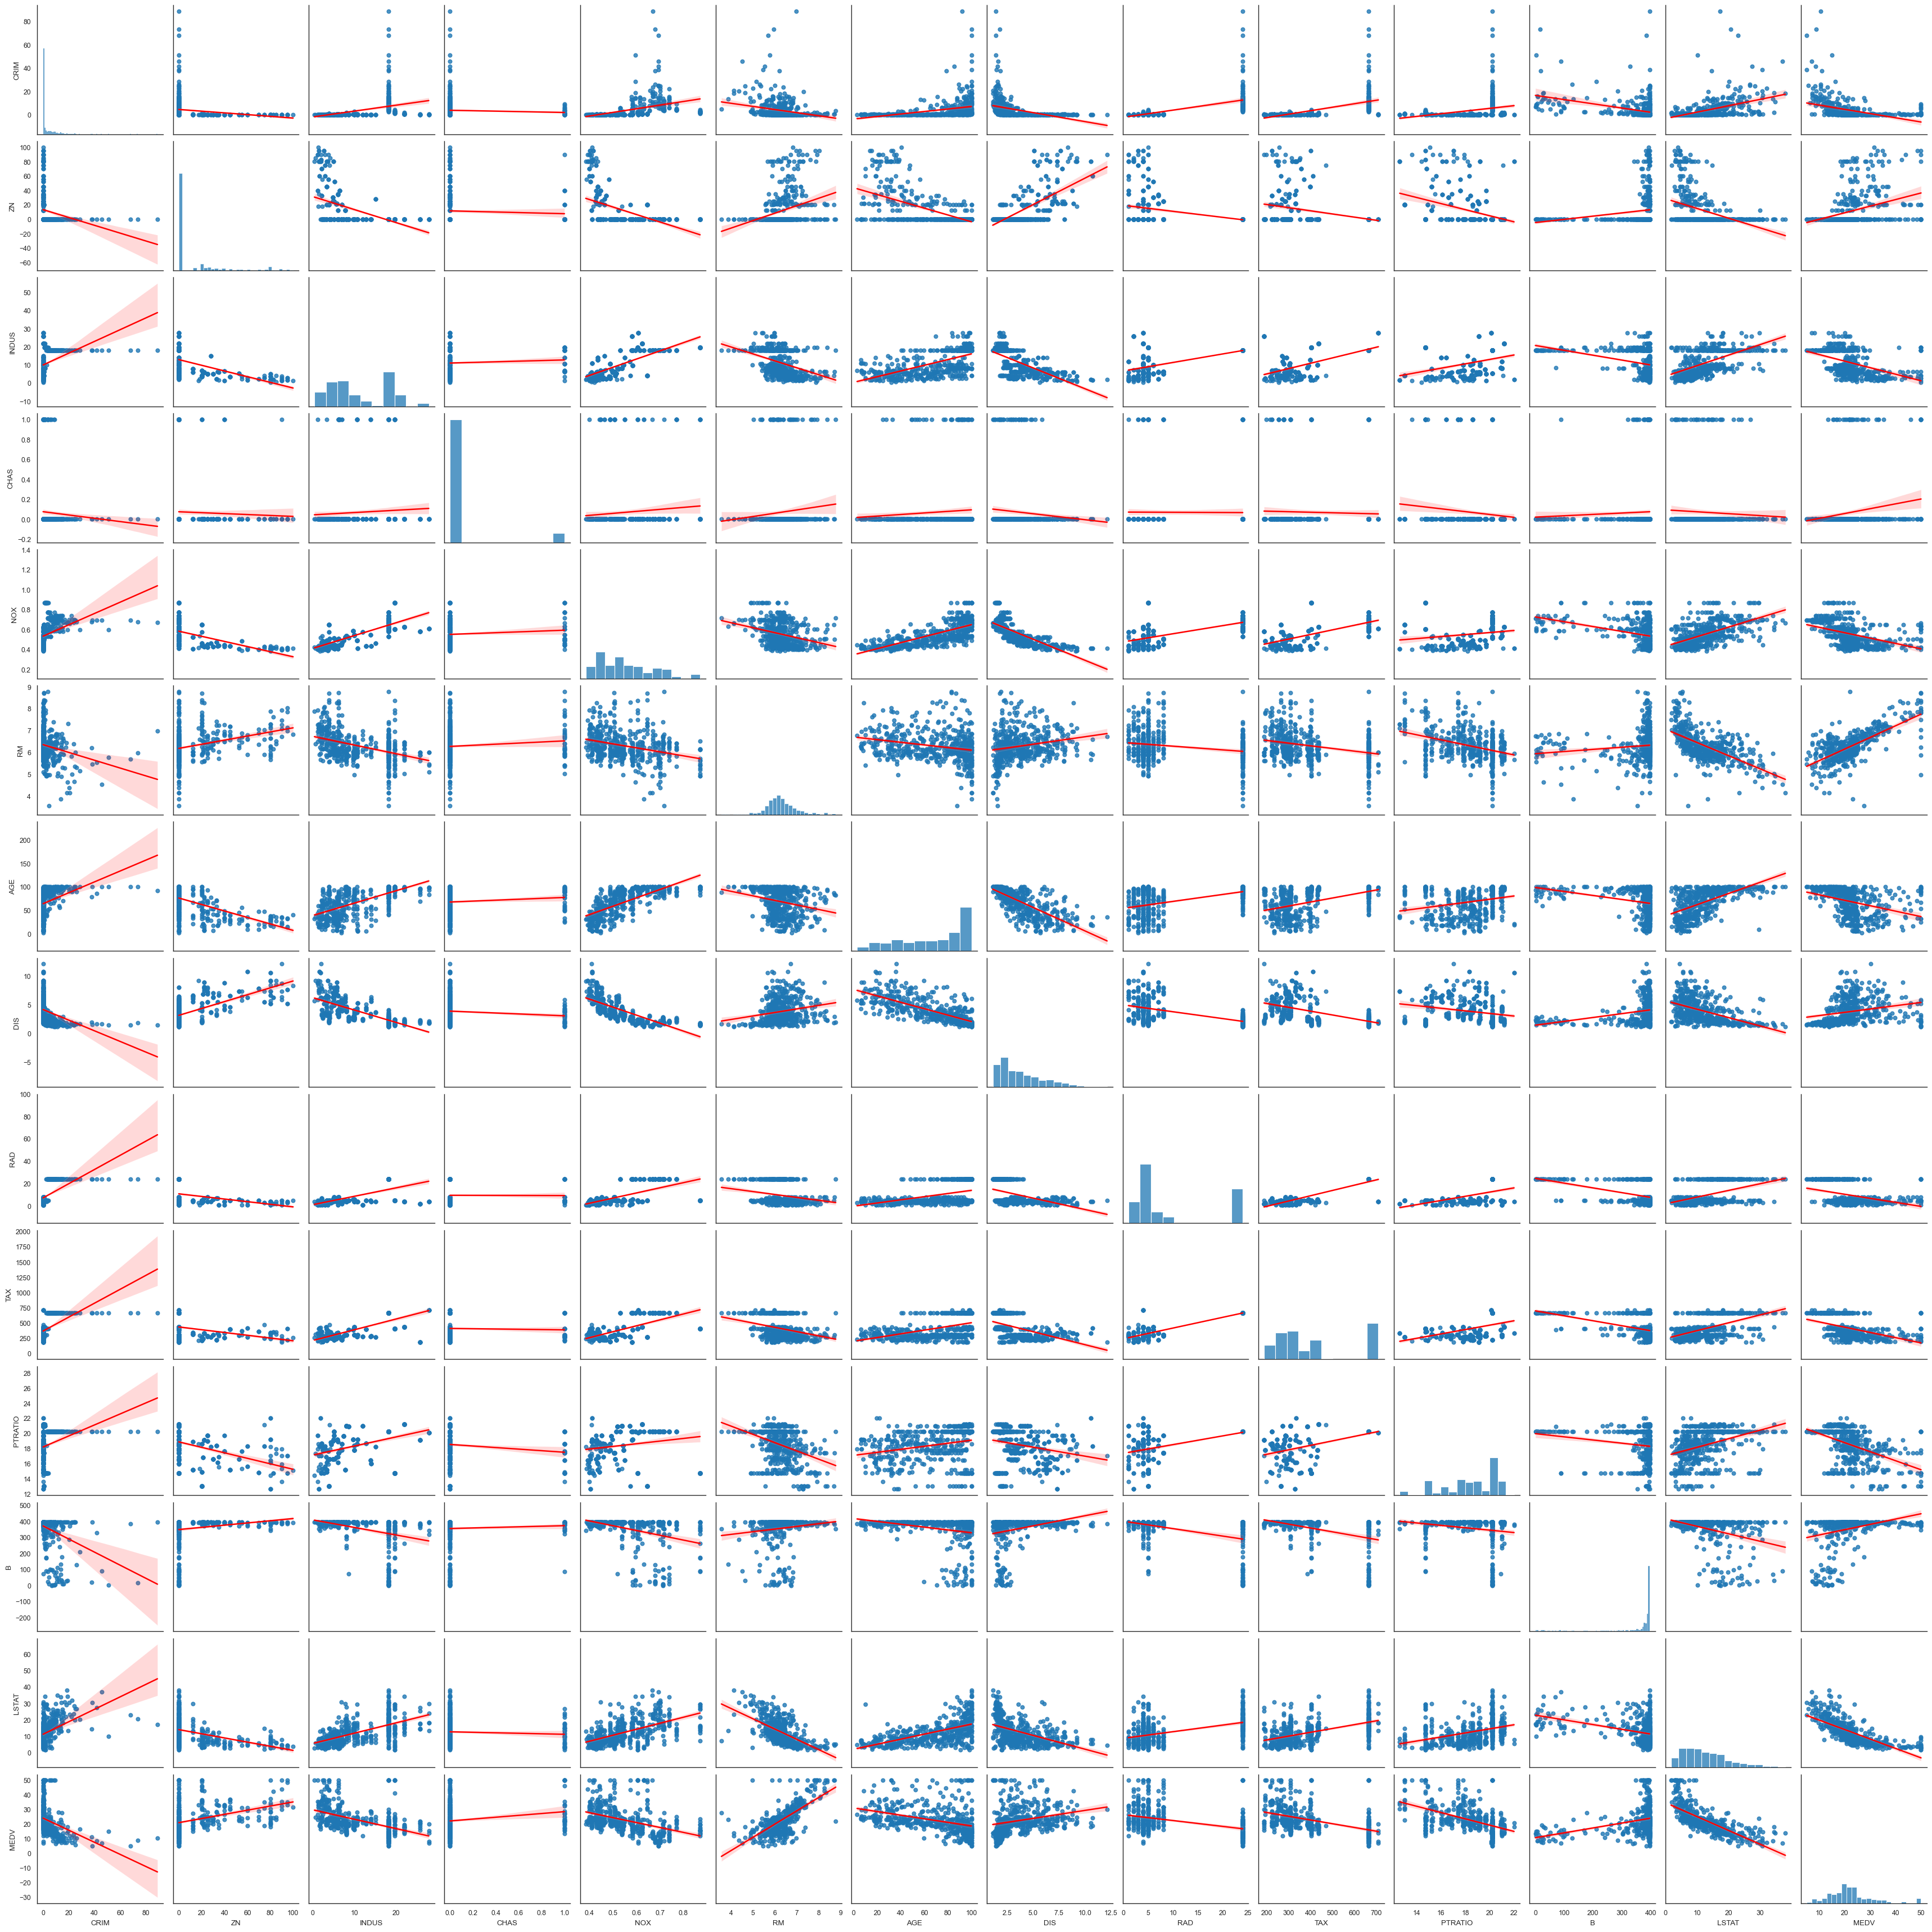

CPU times: user 31.7 s, sys: 293 ms, total: 32 s
Wall time: 32.4 s


In [14]:
%%time

sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color': 'red'}})
plt.show()

## 5) Train & build algorithm: Multiple Regression

### Training & testing sets

In [15]:
features = df.drop('MEDV', axis=1)
target = df['MEDV']
features.head()

# Features is the first array; target is second.
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10) 

### Training Results

In [16]:
# Training data

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
MEDV_y_train1 = reg.predict(X_train)
print('R-squared: ', reg.score(X_train, y_train))
print(pd.DataFrame(reg.coef_, index=X_train.columns, columns=['Coefficients']))
print('Intercept: ', reg.intercept_)

R-squared:  0.750121534530608
         Coefficients
CRIM        -0.128181
ZN           0.063198
INDUS       -0.007576
CHAS         1.974515
NOX        -16.271989
RM           3.108456
AGE          0.016292
DIS         -1.483014
RAD          0.303988
TAX         -0.012082
PTRATIO     -0.820306
B            0.011419
LSTAT       -0.581626
Intercept:  36.53305138282434


### Regression: Actual values vs. predicted

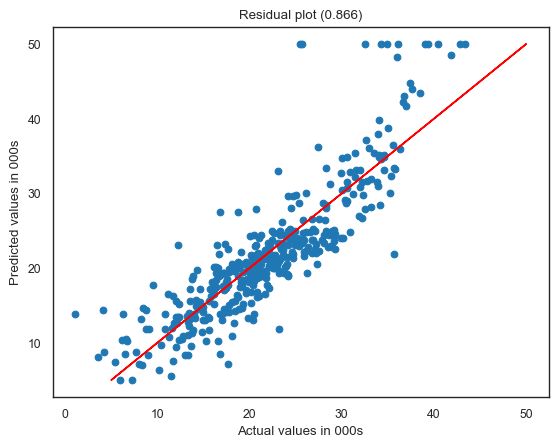

In [17]:
R2 = np.corrcoef(MEDV_y_train1, y_train)[0][1]
plt.scatter(MEDV_y_train1, y_train)
plt.plot(y_train, y_train, color='red')

plt.xlabel('Actual values in 000s')
plt.ylabel('Predicted values in 000s')
plt.title(f'Residual plot ({round(R2, 3)})')

plt.show()

### Assessing the model (e.g. coefficient p-Values)

In [18]:
X_summary1 = sm.add_constant(X_train)

model = sm.OLS(y_train, X_summary1, missing='drop')
model_result1 = model.fit()
print(model_result1.summary())

print(model_result1.resid)
print(model_result1.mse_resid)
print(mse(y_train, MEDV_y_train1))

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     90.06
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          1.12e-108
Time:                        02:32:58   Log-Likelihood:                -1170.5
No. Observations:                 404   AIC:                             2369.
Df Residuals:                     390   BIC:                             2425.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.5331      5.428      6.730      0.0

### A. Checking that there's a linear relationship

### B. Showing that the residuals are independent using the Durbin-Watson statistic


In [19]:
fitted_values = model_result1.fittedvalues
residuals = model_result1.resid
durbin_watson_stat = sm.stats.durbin_watson(residuals, axis=0)

print(durbin_watson_stat)

2.124548455902406


Because the Durbin-Watson test returns a value between 1.5 and 2.5, autocorrelation is likely not a cause for concern.

Therefore, the residuals are independent.

### C. Showing that the residuals display homoscedasticity (i.e. constant variance) using the Breusch-Pagan Test

In [20]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.stats.api.het_breuschpagan(residuals, model_result1.model.exog)
pd.Series(test, index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

Lagrange multiplier statistic    6.254941e+01
p-value                          1.830725e-08
f-value                          5.495618e+00
f p-value                        3.498179e-09
dtype: float64

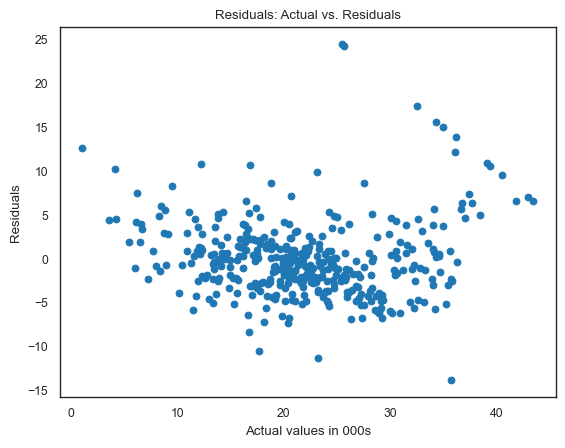

In [21]:
plt.scatter(MEDV_y_train1, model_result1.resid)

plt.xlabel('Actual values in 000s')
plt.ylabel('Residuals')
plt.title(f'Residuals: Actual vs. Residuals')

plt.show()

Since the p-value is less than our significance less (0.05), our regression is homoscedastic.

Source: https://www.statology.org/breusch-pagan-test/

### D. Showing that the residuals display normality

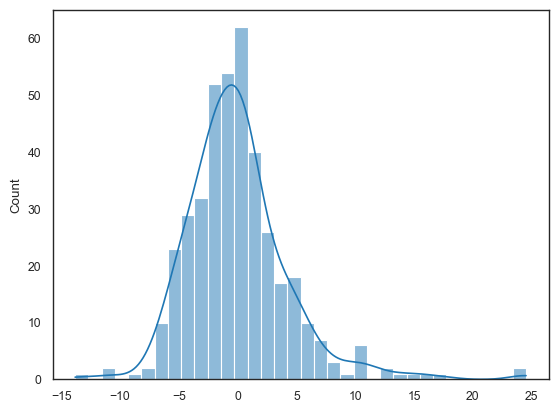

In [22]:
# sm.qqplot(residuals, line='s')

sns.histplot(model_result1.resid, kde=True)
plt.show()

### E. Checking for multicollinearity using the variance influence factor (VIF)

In [23]:
# print(X_train.columns)

VIF_values = pd.Series([round(VIF(X_summary1, i), 2) for i in range(0, len(X_train.columns))], index=X_train.columns)
print(VIF_values)

CRIM       597.55
ZN           1.71
INDUS        2.33
CHAS         3.94
NOX          1.08
RM           4.41
AGE          1.84
DIS          3.33
RAD          4.22
TAX          7.31
PTRATIO      8.51
B            1.84
LSTAT        1.34
dtype: float64


The cutoff for multicollinearity is 10, and none of the features meet that cutoff.

Therefore, we can say that there is no multicollinearity.

## Transforming Regression with Log Prices

In [24]:
log_features = df.drop(['MEDV', 'INDUS', 'AGE'], axis=1) # INDUS, AGE have been dropped for not being statistically significant.
log_target = np.log(df['MEDV'])

# Features is the first array; target is second.
X_train, X_test, y_train, y_test = train_test_split(log_features, log_target, test_size=0.2, random_state=10) 

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
MEDV_y_train2 = reg.predict(X_train)
print('R-squared:', reg.score(X_train, y_train))
print(pd.DataFrame(reg.coef_, index=X_test.columns, columns=['Coefficients']))
print('Intercept:', reg.intercept_)

R-squared: 0.7918657661852815
         Coefficients
CRIM        -0.010702
ZN           0.001461
CHAS         0.086449
NOX         -0.616448
RM           0.076133
DIS         -0.052692
RAD          0.013743
TAX         -0.000590
PTRATIO     -0.033481
B            0.000518
LSTAT       -0.030271
Intercept: 4.03592171504836


### Regression: Actual values vs. predicted

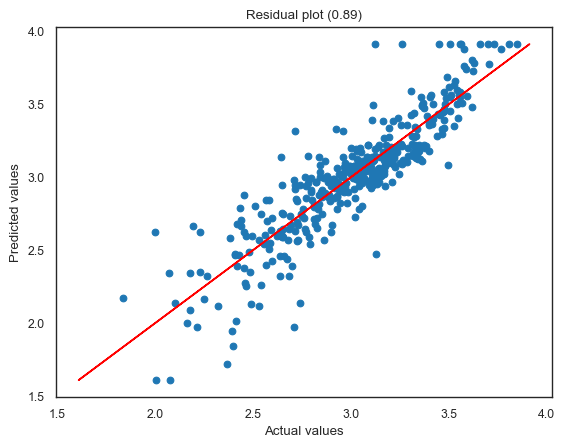

In [25]:
R2 = np.corrcoef(MEDV_y_train2, y_train)[0][1]
plt.scatter(MEDV_y_train2, y_train)
plt.plot(y_train, y_train, color='red')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f'Residual plot ({round(R2, 3)})')

plt.show()

### Assessing the model (e.g. coefficient p-Values)

In [26]:
X_summary2 = sm.add_constant(X_train)

model = sm.OLS(y_train, X_summary2, missing='drop')
model_result2 = model.fit()
print(model_result2.summary())

print(model_result2.resid)
print(model_result2.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     135.6
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          3.68e-126
Time:                        02:33:25   Log-Likelihood:                 110.76
No. Observations:                 404   AIC:                            -197.5
Df Residuals:                     392   BIC:                            -149.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0359      0.226     17.819      0.0

### A. Checking that there's a linear relationship

### B. Showing that the residuals are independent using the Durbin-Watson statistic


In [27]:
fitted_values = model_result2.fittedvalues
residuals = model_result2.resid
durbin_watson_stat = sm.stats.durbin_watson(residuals, axis=0)

print(durbin_watson_stat)

2.0716128816841124


Because the Durbin-Watson test returns a value between 1.5 and 2.5, autocorrelation is likely not a cause for concern.

Therefore, the residuals are independent.

### C. Showing that the residuals display homoscedasticity (i.e. constant variance) using the Breusch-Pagan Test

In [28]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.stats.api.het_breuschpagan(residuals, model_result2.model.exog)
pd.Series(test, index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

Lagrange multiplier statistic    5.792609e+01
p-value                          2.245454e-08
f-value                          5.964839e+00
f p-value                        5.194101e-09
dtype: float64

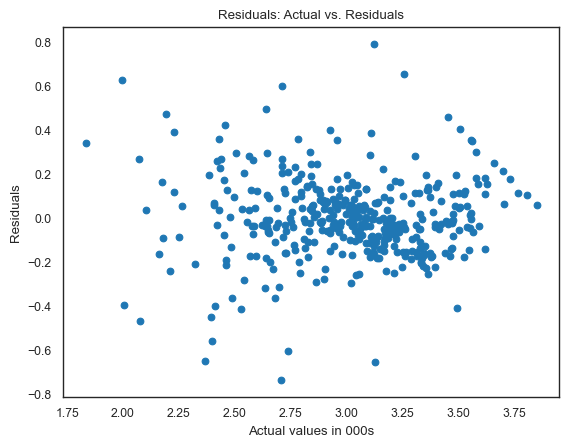

In [29]:
plt.scatter(MEDV_y_train2, model_result2.resid)

plt.xlabel('Actual values in 000s')
plt.ylabel('Residuals')
plt.title(f'Residuals: Actual vs. Residuals')

plt.show()

Since the p-value is less than our significance less (0.05), our regression is homoscedastic.

Source: https://www.statology.org/breusch-pagan-test/

### D. Showing that the residuals display normality

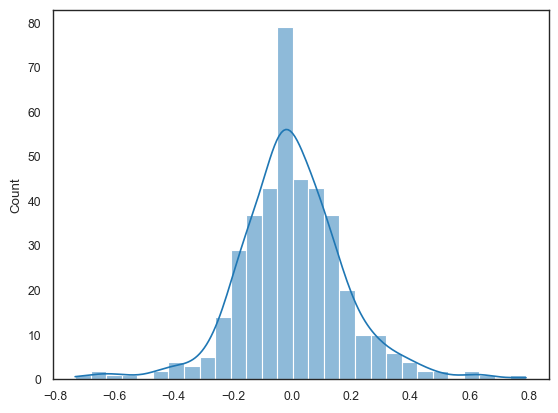

In [30]:
# sm.qqplot(residuals, line='s')

sns.histplot(model_result2.resid, kde=True)
plt.show()

### E. Checking for multicollinearity using the variance influence factor (VIF)

In [31]:
# print(X_train.columns)

VIF_values = pd.Series([round(VIF(X_summary2, i), 2) for i in range(0, len(X_train.columns))], index=X_train.columns)
print(VIF_values)

CRIM       594.28
ZN           1.71
CHAS         2.29
NOX          1.07
RM           3.83
DIS          1.75
RAD          3.59
TAX          6.79
PTRATIO      7.11
B            1.79
LSTAT        1.33
dtype: float64


The cutoff for multicollinearity is 10, and none of the features meet that cutoff.

Therefore, we can say that there is no multicollinearity.

### Test Results

In [34]:
# Test data

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
MEDV_y_test = reg.predict(X_test)  # Predict on test data
print('R-squared:', reg.score(X_test, y_test))
print(pd.DataFrame(reg.coef_, index=X_test.columns, columns=['Coefficients']))
print('Intercept:', reg.intercept_)

R-squared: 0.7490934185196063
         Coefficients
CRIM        -0.010702
ZN           0.001461
CHAS         0.086449
NOX         -0.616448
RM           0.076133
DIS         -0.052692
RAD          0.013743
TAX         -0.000590
PTRATIO     -0.033481
B            0.000518
LSTAT       -0.030271
Intercept: 4.03592171504836


### How well does the training set fit the test set? Do new data points (i.e. test set) have similar coefficients, MSE, R-Squared, etc. as the training set?

In [35]:
# R-squared scores
r2_train = reg.score(X_train, y_train)
r2_test = reg.score(X_test, y_test)

# We need to make predictions first
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Mean Squared Error (MSE)
mse_train = mse(y_train, MEDV_y_train1)
mse_test = mse(y_test, MEDV_y_test)

# Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Print metrics side by side
print(f"{'Metric':<10} {'Training':>12} {'Testing':>12}")
print('-' * 35)
print(f"{'R²':.<10} {r2_train:>12.4f} {r2_test:>12.4f}")
print(f"{'MSE':.<10} {mse_train:>12.4f} {mse_test:>12.4f}")
print(f"{'RMSE':.<10} {rmse_train:>12.4f} {rmse_test:>12.4f}")

Metric         Training      Testing
-----------------------------------
R²........       0.7919       0.7491
MSE.......     407.3670       0.0419
RMSE......      20.1833       0.2046


### Regression: Actual values vs. predicted

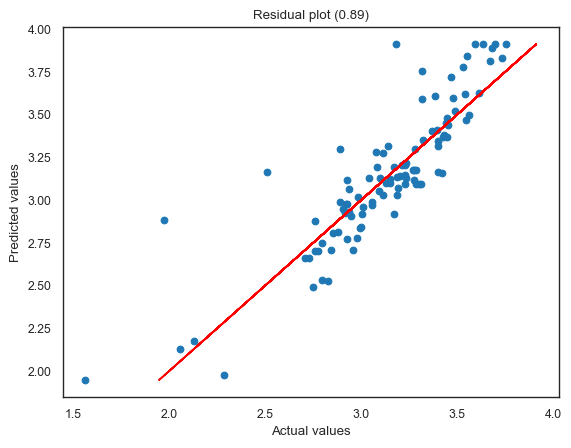

In [36]:
R3 = np.corrcoef(MEDV_y_test, y_test)[0][1]
plt.scatter(MEDV_y_test, y_test)
plt.plot(y_test, y_test, color='red')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f'Residual plot ({round(R2, 3)})')

plt.show()

In [37]:
X_summary3 = sm.add_constant(X_test)

model = sm.OLS(y_test, X_summary3, missing='drop')
model_result3 = model.fit()
print(model_result3.summary())

print(model_result3.resid)
print('Mean absolute error:', model_result3.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     33.08
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           6.22e-27
Time:                        02:37:25   Log-Likelihood:                 29.106
No. Observations:                 102   AIC:                            -34.21
Df Residuals:                      90   BIC:                            -2.712
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3113      0.473      9.122      0.0

### A. Checking that there's a linear relationship

### B. Showing that the residuals are independent using the Durbin-Watson statistic


In [40]:
fitted_values = model_result3.fittedvalues
residuals = model_result3.resid
durbin_watson_stat = sm.stats.durbin_watson(residuals, axis=0)

print(durbin_watson_stat)

1.9925897546011744


Because the Durbin-Watson test returns a value between 1.5 and 2.5, autocorrelation is likely not a cause for concern.

Therefore, the residuals are independent.

### C. Showing that the residuals display homoscedasticity (i.e. constant variance) using the Breusch-Pagan Test

In [41]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.stats.api.het_breuschpagan(residuals, model_result3.model.exog)
pd.Series(test, index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

Lagrange multiplier statistic    23.792137
p-value                           0.013639
f-value                           2.489046
f p-value                         0.008936
dtype: float64

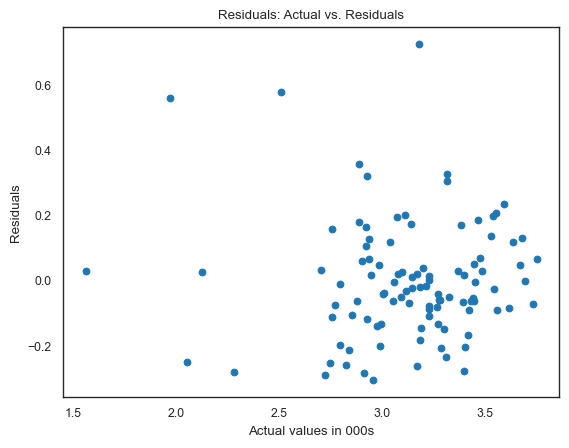

In [42]:
plt.scatter(MEDV_y_test, model_result3.resid)

plt.xlabel('Actual values in 000s')
plt.ylabel('Residuals')
plt.title(f'Residuals: Actual vs. Residuals')

plt.show()

Since the p-value is less than our significance less (0.05), our regression is homoscedastic.

Source: https://www.statology.org/breusch-pagan-test/

### D. Showing that the residuals display normality

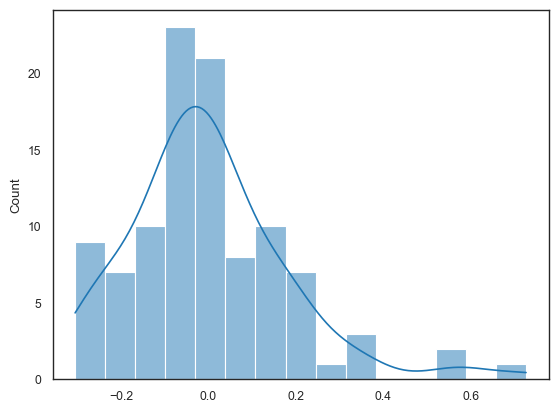

In [43]:
# sm.qqplot(residuals, line='s')

sns.histplot(model_result3.resid, kde=True)
plt.show()

### E. Checking for multicollinearity using the variance influence factor (VIF)

In [44]:
# print(X_train.columns)

VIF_values = pd.Series([round(VIF(X_summary3, i), 2) for i in range(0, len(X_test.columns))], index=X_test.columns)
print(VIF_values)

CRIM       607.66
ZN           2.97
CHAS         2.23
NOX          1.05
RM           3.97
DIS          2.31
RAD          2.99
TAX          7.50
PTRATIO      8.29
B            1.68
LSTAT        1.63
dtype: float64


The cutoff for multicollinearity is 10, and none of the features meet that cutoff.

Therefore, we can say that there is no multicollinearity.

## 6) Evaluation: How well does the model do?

In [47]:
confidence_level = 0.95
alpha = 1 - confidence_level
df = 390  # degrees of freedom
t_value = stats.t.ppf(1 - alpha/2, df)

rmse = math.sqrt(0.03487337082354599)

standard_error_predict = rmse * math.sqrt(1 * (1/390))

margin_error = t_value * standard_error_predict

prediction_error_plus = 35000 + margin_error
prediction_error_minus = 35000 - margin_error

print(f"The prediction interval is {prediction_error_minus} <= 35000 <= {prediction_error_plus}")


The prediction interval is 34999.98140857814 <= 35000 <= 35000.01859142186
